# Project

## Team Information
Juan Leaniz Pittamiglio

Student ID: 

jleaniz@my.yorku.ca

## Overview
Most consumers read online reviews before visiting a business or using a service. The reviews not only provide customers with important information for making their decisions, but also help businesses get key insights from their customers and make improvements based on customer feedbacks. In this project, i was given a training data set that contains Yelp reviews of businesses (such as restaurants, home services, auto services, etc.). The reviews in the training dataset are labeled as positive, negative or neutral, and the goal is to build a classifier based on the training data.

Considering that the training dataset contains labeled samples, a supervised learning approach is appropriate for this problem. As such, I have selected three supervised learning algorithms to train classifier models.

This project utilizes scikit-learn, a Python library for machine learning. I selected scikit-learn as it provides the ability to easily perform tasks such as text pre-processing, hyperparamater search and dataset splits. Furthermore, scikit-learn supports a wide variety of learning algorithms, including the ones used in this project. Scikit-learn also provides the ability to validate the accuracy of any trained models by utilizing different measures such as precision, recall, f-measure and overall accuracy using a weighted average of these measures.

All these features allowed me to pre-process the datasets, train various models using different supervised learning algorithms and then validate their accuracy using a train/test dataset split.

Finally, selecting the best model is a matter of finding a balance between the different accuracy measures and then using the model to make predictions on an unlabeled dataset that was provided as part of this project.


## Datasets
This section describes the different datasets used within this project.

**train3.csv**: This dataset contains 50,000 samples of Yelp reviews. The samples are labeled as positive, negative or neutral reviews.

**test3.csv**: This test set contains **unlabeled** samples which will be classified by our model.

**preprocessed_train3.csv**: This is the training dataset after removing stop words. This dataset is not used to train the models and is only here to meet project requirements of providing a processed training dataset in .arff format for Weka. All text pre-processing in the main program for this project (**trainer.py**) is performed directly by utilizing scikit-learn functions within TfidfVectorizer.


# Load required Python libraries
In order to run the program, the following requirements need to be met:
- Python 3.7
- Pandas
- Scikit-learn

Install them via **pip3 install pandas scikit-learn** in the command line.

Alternatively, the packages can be installed by running **pip install -r requirements.txt**

In [187]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

################## CONFUGIRATION ##################
# Set to True to perform an exhaustive parameter grid search
# WARNING: It will take a long time to train if set to True
param_grid_search = False 

# Number of folds for cross validation
# NOTE: Only used if param_grid_search is True
k_fold = 3 

# Absolute path to the datasets - MUST be configured
train_dataset_path='train3.csv'
test_dataset_path='test3.csv'
stop_words_path='stop_words.txt'

# Data Analysis: Exploring the Training dataset

Our first step is to explore the dataset and identify any potential issues we may encounter when pre-processing the text reviews (e.g. special characters, bad grammar, etc), or any imbalances with the number of labaled samples.


In [172]:
df = pd.read_csv("train3.csv")

In [173]:
df.columns

Index(['text', 'class', 'ID'], dtype='object')

The number of reviews for each class is: 
 positive    38348
negative    11897
neutral      5755
Name: class, dtype: int64


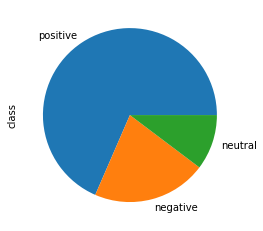

In [174]:
print("The number of reviews for each class is: \n",df['class'].value_counts())

df['class'].value_counts().plot(kind='pie')

Frequency of words in original training dataset: 


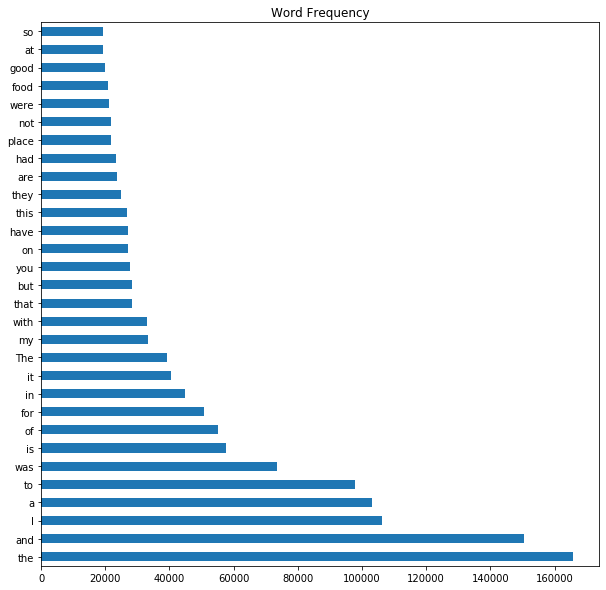

In [175]:
print("Frequency of words in original training dataset: ")
df.text.str.split(expand=True).stack().value_counts().head(30).plot(kind='barh',figsize=(10, 10), title='Word Frequency')


# Data Analysis: Observations and Challenges with the Dataset

## Frequent words

As can be seen in the bar chart above, a lot of words are repeated thousands of times. These words are good candidates to be used as stop words. See **Appendix A** for more details on stop word removal.

## Imbalanced dataset problem

In the training dataset that was provided, the number of **neutral** samples is significantly lower than the number of **positive** or **negative** reviews. This will likely have an adverse effect when training a classifier model and affect the model's accuracy when classifying reviews for the **neutral** class. We were not able to identify a way to overcome this problem with the provided dataset without adding additional samples of the **neutral** class.

## Imbalanced dataset solution

Part of the pre-processing step was to find a way to overcome imbalancing of the training dataset samples. We performed a resampling of the **neutral** class samples. More specifically, the approach was to upsample the minority class **neutral** to match the number of samples in the negative class. This helped balance the number of samples in each class to a more realistic distribution.

The **upsample_minority_class()** function implements the approach described above.

The **downsample_majority_class()** function implements a similar approach to downsample the **positive** majority class 

In [176]:
def upsample_minority_class(df):
    '''
    This function performs up-sampling of the class with fewer samples
    to balance the training dataset more evenly.
    '''
    df_positive = df[df['class'] == 'positive']
    df_negative = df[df['class'] == 'negative']
    df_neutral = df[df['class'] == 'neutral']

    df_neutral_upsampled = resample(df_neutral, 
         replace=True,    # sample with replacement
         n_samples=11897, # to match negative class
         random_state=42 # to have reproducible results over multiple runs 
    )
    
    # Combine with upsampled minority class
    df_upsampled = pd.concat([df_positive, df_negative, df_neutral_upsampled])
    return df_upsampled

def downsample_majority_class(df):
    '''
    This function performs down-sampling of the class with fewer samples
    to balance the training dataset more evenly.
    '''
    df_positive = df[df['class'] == 'positive']
    df_negative = df[df['class'] == 'negative']
    df_neutral = df[df['class'] == 'neutral']

    df_positive_downsampled = resample(df_positive, 
         replace=False,    # sample without replacement
         n_samples=20000, # downsample to 20,000 samples
         random_state=42 # to have reproducible results over multiple runs 
    )
    
    # Combine with downsampled majority class
    df_downsampled = pd.concat([df_neutral, df_negative, df_positive_downsampled])
    return df_downsampled


# Training Pipeline

The Pipeline consists of three main steps.
    
1. Text pre-processing:

    The **TfidfVectorizer()** class will perform the following steps on the training data:
    
    - **Strip unwanted accentuated characters** such as '!'. This helps the model tolerate inputs where some reviews may have a lot of accentuated characters enter by the reviewer.
    - Convert all characters in the review text to **lowercase** for consistency.
    - **Remove stop words** defined in the variable 'stop_words' from all reviews in the training dataset.


2. Feature extraction:

    The **TfidfVectorizer()** class from scikit-learn will convert the text the reviews to a matrix of token counts. Subsequently, the **TfidfVectorizer()** class from scikit-learn will calculate a token count matrix and produce a normalized **TF-IDF** representation matrix. The goal of utilizing TF-IDF is to reduce the importance of certain tokens that may be repeated very often in the reviews, even after stop word removal. For example, non-stop words may be common in the reviews but have low importance as features.


3. Model training:

    The third and last step is to train three (3) models using different classification algorithms. The algorithms we selected were:
    - **linear Support Vector Machine**: This is accomplished by calling the fit() function in the **SGDClassifier()** class from scikit-learn. **SGDClassifier()** uses _Stochastic Gradient Descent_ for training. 
   
    - **Logistic Regression Classifier**: This is accomplished by calling the fit() function in the **LogisticRegression()** class from scikit-learn. 
    
    - **Random Forest Classifier**: This is accomplished by calling the fit() function in the **RandomForestClassificer()** class from scikit-learn.

For this project, I decided to utilize scikit-learn's **Pipeline** to make it easier to process the training data using **TfidfVectorizer** and then train the different models. The **fit_classifier()** function wraps all of the above functionality.
    
To train the models, a **70/30 split** is performed on the training dataset. The split is performed to train the model on 70% of the dataset and validate its accuracy with the remaining 30%. 

## Support Vector Machines
**Support vector machines (SVMs)** fit the type of problem we are trying to solve. Our goal is to classify text utilizing a labeled dataset with multiple class.

SVMs are suitable for s supervised training environment and can be used for **multiclass classification**, which is exactly what we need in this project.

Further, some of the advantages of support vector machines are:
- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

## Logistic Regression Classifier
**Logistic Regrssion** is a Machine Learning algorithm which is used for the classification problems, it is a predictive analysis algorithm and based on the concept of probability. In the context of this project, we are presented with a Multi-class classification problem. In order to use logistic regression, the strategy used by scikit-learn is to perform a transformation. In other words, to reduce the multi-class problem into multiple binary classification problems. The scheme selected to perform this task is One-vs.-Rest, a strategy that involves training a single classifier per class, with the samples of that class as positive samples and all other samples as negatives. When making predictions, OvR will predict the label of a sample using all trained classifiers and select the one with the highest confidence score.

## Random Forest Classifier
**Random Forest Classifier** is a machine learning algorithm which consists of a large number of individual decision trees which operate as an ensemble. In essence, each individual decision tree predicts a class label and the label with most votes becomes the final model's prediction. The main concept behind Random Forest is that a large number of relatively uncorrelated models (trees in this case) operating as a committee will outperform any of the individual models.

# Training and Validation split datasets
This section describes the function used to load, process and split the initial training dataset. 

The **load_and_split()** function performs four main steps:

1. Load the training dataset
2. Perform resampling (upsampling and downsampling of minitory and majority classes respectively)
3. Save the processed training dataset as 'processed_train3.csv'
3. Perform a 70/30 split and return the data


In [177]:
def load_and_split():
    '''
    This function loads the train3.csv dataset from the assignment and performs
    pre-processing tasks such as stop word removal and train/test split
    
    return: x_train: 'text' values used for training
            x_test: 'text' values used for testing accuracy of the model
            y_train: 'class' values used for training
            y_test: 'class' values used for testing accuracy of the model
    '''
    df = pd.read_csv(train_dataset_path)
    df = upsample_minority_class(df)
    df = downsample_majority_class(df)
    df = df.set_index('ID')
    
    x = df['text']
    y = df['class']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
   
    return (x_train, x_test, y_train, y_test)


#  Feature Extraction and Multi-class Text Classification
This section describes the main part of the program which creates and trains different classifiers according to specified parameters. Some flexibility is given to the user in order to tune parameters and whether the user would like to perform a hyperparameter grid search with k-fold cross validation, or just a simple 70/30 split for training the models.

**By default, the program will perform a 70/30 split as it is faster to compute than hyperparameter and cross-validation.**

The **fit_classifier()** function will perform the following steps:

1. Laern a vocabulary from the training dataset by **extracting features** using counts and term frequencies (TF-IDF   with TfidfVectorizer).
2. **Train** SVM, Logistic Regression and Random Forest classifier models.
3. If configured:
    - Perform an exhaustive **hyperparameter grid search** to tune classifier parameters (**optional**).
    - Perofrm k-fold cross validation (**optional**)
4. Return a trained model.



In [178]:
def fit_classifier(x_train, y_train, classifier, param_search, n):
    '''
    This function trains a classifier model using a scikit-learn Pipeline.

    Performing a parameter grid search with k-fold cross-validation is optional
    and can be enabled by setting 'param_grid_search' to True.

    x_train: 'text' values used for training the model
    y_train: 'class' values used for training the model
    classifier: 'svm', 'logreg', 'rf'
    param_search: boolean value, True or False
    n: cross validation n-fold (integer)
    
    return: trained SVM classifier
    '''
    
    # Load stop words from stop_words.txt
    try:
        f = open(stop_words_path, 'r')
        stop_words_list = f.read().split('\n')
        f.close()
    except OSError as err:
        print("OS error: {0}".format(err))

    if classifier == 'svm':    
        parameters = {
            'sgd__max_iter':[500,2000,2000],
            'sgd__n_iter_no_change': [5, 10, 20],
            'sgd__class_weight': ('balanced', None)
        }
        pipe = Pipeline([
            ('tfidf', TfidfVectorizer(strip_accents='unicode', stop_words=stop_words_list, min_df=3, ngram_range=(1,2))),
            ('sgd', SGDClassifier(n_jobs=-1))
        ])
        
    elif classifier == 'logreg':
        parameters = {
            'lr__max_iter':[1000,2000,10000],
            'lr__class_weight': ('balanced',None),
            'lr__solver': ('saga', 'newton-cg', 'lbfgs'),
            'lr__penalty': ('l2', 'elasticnet')                   
        }
        pipe = Pipeline([
            ('tfidf', TfidfVectorizer(strip_accents='unicode',stop_words=stop_words_list,  min_df=3, ngram_range=(1,2))),
            ('lr', LogisticRegression(solver='liblinear',multi_class='auto'))
        ])
        
    elif classifier == 'rf':
        parameters = {
            'rf__n_estimators':[100,500,1000],
            'rf__criterion': ('gini', 'entropy')
        }
        pipe = Pipeline([
            ('tfidf', TfidfVectorizer(strip_accents='unicode', stop_words=stop_words_list, min_df=3, ngram_range=(1,2))),
            ('rf', RandomForestClassifier(n_estimators=500, criterion='gini',n_jobs=-1))
        ])
        
    else:
        print("Invalid classifier option")
        return
    
    if param_search:
        # parameter grid search + cross validation
        model = GridSearchCV(pipe, parameters, n_jobs=-1, cv=n)
        model.fit(x_train, y_train)
    else:
        # cross validation only
        model = pipe.fit(x_train, y_train)
        
    return model

'''
Split the 'train3' dataset into train and test datasets which we will use to train
the SVM classifier and test the accuracy of the model
'''
x_train, x_test, y_train, y_test = load_and_split()

# Train the models
print("=== Training a Linear SVM Classifier ===")
sgd = fit_classifier(x_train, y_train, 'svm', param_grid_search, k_fold)
print("=== Training a Logistic Regression Classifier ===")
logreg = fit_classifier(x_train, y_train, 'logreg', param_grid_search, k_fold)
print("=== Training a Random Forest Classifier ===")
rf = fit_classifier(x_train, y_train, 'rf', param_grid_search, k_fold)


=== Training a Linear SVM Classifier ===
=== Training a Logistic Regression Classifier ===
=== Training a Random Forest Classifier ===


# Choosing a Classifier
The approach to choosing the best possible classifier is outlined below. 

Note that this process was only done one time and is disabled by default due to the amount of time it takes to perform all the steps with all the different combination of hyperparameters.

1. Define a parameter grid for each of the three classifier algorithms:

    Support Vector Machines
    
    parameters = {
        'sgd__max_iter':[500,2000,2000],
        'sgd__n_iter_no_change': [5, 10, 20],
        'sgd__class_weight': ('balanced', None)
    }
    
    Logistic Regression Classifier
    
    parameters = {
        'lr__max_iter':[1000,2000,10000],
        'lr__class_weight': ('balanced',None),
        'lr__solver': ('saga', 'newton-cg', 'lbfgs'),
        'lr__penalty': ('l2', 'elasticnet')                   
    }_
    
    Random Forest Classifier
    
    
    parameters = { 
    'rf__n_estimators':[100,500,1000],
    'rf__criterion': ('gini', 'entropy')
    }


2. Perform a hyperparameter grid search using k-fold cross validation.
3. Examine the accuracy of the best classifier for each of the three algorithms.
4. Select the model with the highest f1-score.
    - **_The f1-score is a measure of the model's accuracy based on both precision and recall and is a balanced approach_**
5. Obtain the specific training parameters that generated the model.

# Best model
In my tests, the model with the highest f1-score was a Random Forest classifier with the following training hyperparameters:

{

'rf__criterion': 'gini',

'rf__n_estimators': 500

}

**n_estimators**: This parameter sets the number of trees to 500.

**criterion**: This parameter sets the split method for the decision trees to 'Gini' score. 

# Testing Model Accuracy

In this step we make predictions on the **test** dataaset from the previous 70/30 dataset split.

This will allow us to estimate the model's accuracy by validating the classifications with a subset of pre-labeled reviews (hold-out test set).

In [179]:
def validate_classifier(model, model_name, x_test, y_test):
    '''
    Predict values using the validation test set from our 70/30 split
    and output accuracy of the models
    '''
    # Define list of classes in the dataset
    data_classes = ['positive', 'negative', 'neutral']

    y_pred = model.predict(x_test)
    print(model_name,' accuracy is: ', accuracy_score(y_test, y_pred),'\n')
    print(classification_report(y_test, y_pred,target_names=data_classes))
    report = classification_report(y_test, y_pred,target_names=data_classes, output_dict=True)
    return report

# Test the accuracy of the models using the validation test set from the split
svm_report = validate_classifier(sgd, 'Linear SVM Classifier', x_test, y_test)
logreg_report = validate_classifier(logreg, 'Logistic Regression Classifier', x_test, y_test)
rf_report = validate_classifier(rf, 'Random Forest Classifier', x_test, y_test)

# Print the name and accuracy of the best model
f_measure_scores = {
    'linear_svm': svm_report['weighted avg']['f1-score'],
    'logistic_reg': logreg_report['weighted avg']['f1-score'],
    'random_Forest': rf_report['weighted avg']['f1-score']
}
best_f_measure = f_measure_scores[max(f_measure_scores, key=f_measure_scores.get)]
best_model_name = list(f_measure_scores.keys())[list(f_measure_scores.values()).index(best_f_measure)]
print("Best model (using f1-score/f-measure): name=",best_model_name,'avg f1-score=', best_f_measure,"\n")


Linear SVM Classifier  accuracy is:  0.8230593607305936 

              precision    recall  f1-score   support

    positive       0.84      0.81      0.82      1196
    negative       0.79      0.66      0.72      1154
     neutral       0.83      0.93      0.88      2030

    accuracy                           0.82      4380
   macro avg       0.82      0.80      0.80      4380
weighted avg       0.82      0.82      0.82      4380

Logistic Regression Classifier  accuracy is:  0.8328767123287671 

              precision    recall  f1-score   support

    positive       0.86      0.80      0.82      1196
    negative       0.78      0.71      0.74      1154
     neutral       0.84      0.93      0.88      2030

    accuracy                           0.83      4380
   macro avg       0.83      0.81      0.82      4380
weighted avg       0.83      0.83      0.83      4380

Random Forest Classifier  accuracy is:  0.8867579908675799 

              precision    recall  f1-score   suppor

# Classification of unlabeled dataset using the best model

Now that we have chosen a classifier we can make predictions on the **test3.csv** dataset provided. This will predict a class for each of the samples in the test3.csv dataset which is completely unlabeled.

Scikit-learn will utilize the same Pipeline used to train the model to make predictions. This means that it will **generate TF-IDF values for each term of each review in the test3.csv dataset automatically**.

In [180]:
# Predict values for the unlabeled dataset
df_rf_pred = pd.read_csv("test3.csv")
df_rf_pred = df_rf_pred.set_index('ID')
rf_preds = rf.predict(df_rf_pred['text'])
rf_preds

array(['negative', 'negative', 'positive', ..., 'positive', 'positive',
       'positive'], dtype=object)

# Formatting Predicted Output

The final step is to format our predicted output (classifications) in accordance with the Project specifications. The format of the prediction.csv file should be as follows:

**_REVIEW-ID, CLASS_**

_123, positive_

_456, neutral_

_789, negative_

The order of the REVIEW-IDs is the same as the order of the IDs in test3.csv

In [181]:
df_rf_pred['CLASS'] = rf_preds
#df_rf_pred.to_csv('output_rf.csv')
df_rf_pred.index.names = ['REVIEW-ID']
df_rf_pred = df_rf_pred.drop(columns=['text'])
df_rf_pred

,CLASS
REVIEW-ID,
344,negative
2324,negative
3217,positive
3705,positive
3959,negative
...,...
6662447,negative
6662575,negative
6664830,positive


In [182]:
# Save the predicted outputs to a csv file
print("Saving predicted outputs to prediction.csv at the current working directory\n")
df_rf_pred.to_csv("prediction.csv")
print("=== PREDICTED CLASS VALUE COUNT ===")
print("Total reviews in the test dataset: ", len(df_rf_pred))
print("Number of reviews per class: \n", df_rf_pred['CLASS'].value_counts())
print("\nAll tasks completed.")

Saving predicted outputs to prediction.csv at the current working directory

=== PREDICTED CLASS VALUE COUNT ===
Total reviews in the test dataset:  13999
Number of reviews per class: 
 positive    10903
negative     2964
neutral       132
Name: CLASS, dtype: int64

All tasks completed.


# Conclusions
Using the trained **Random Forest** model to classify the test data yields the following overall results:

In [183]:
print("Total reviews in the test dataset: ", len(df_rf_pred))
print("Number of reviews per class: \n", df_rf_pred['CLASS'].value_counts())

Total reviews in the test dataset:  13999
Number of reviews per class: 
 positive    10903
negative     2964
neutral       132
Name: CLASS, dtype: int64


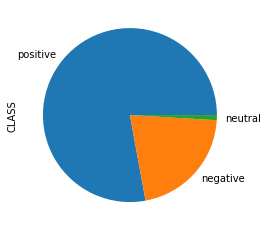

In [184]:
df_rf_pred['CLASS'].value_counts().plot(kind='pie')

The ratio of reviews classifed in the test dataset as positive, negative and neutral is somewhat similar to the ratio of reviews in each class in the labeled training dataset. An important factor in obtaining these results was the need to balance the training dataset classes. Without performing up-sampling or down=sampling of the minority and majority classes respectively, the models that were initially trained were very inaccurate when predicting outputs in the neutral and negative classes. In fact, in some cases the model would not predict any outputs in the neutral class at all. Once the dataset was balanced, the classifiers performed much better on average.

As outlined in the **Testing Model Accuracy** section, the Random Forest classifier had the highest weighted average f1-score in comparison to the models produced by the logisitic regression and Support Vector Machines learning algorithms. It was interesting to see that by utilizing an ensemble approach such as Random Forest I was able to obtain better predictive performance on the training dataset.

# Appendix A: Text pre-processing script
In the main program, I utilize scikit-learn to perform the text pre-processing (i.e. removing stop words, etc). Given that the pre-processing and generation of term frequencies is part of a Pipeline, the processed training dataset was not easily accessible for exporting. To overcome this problem and meet the project requirement of providing a processed training dataset in CSV and ARFF formats, I created the script outlined in the section below.

In [186]:
import pandas as pd

def remove_stop_words(text):
    '''
    This function is used to decode the base64 stop words
    No need to modify this
    
    text: some text
    return: list of stop words
    '''
    try:
        text = text.split()
        resultwords  = [word.lower() for word in text if word.lower() not in stop_words]
        result = ' '.join(resultwords)
        return result
    except:
        print("Error removing stop words!")
        exit(1)

def main():
    df = pd.read_csv("train3.csv")
    df = upsample_minority_class(df)
    df = downsample_majority_class(df)
    df['text'] = df['text'].apply(remove_stop_words)
    df = df.set_index('ID')
    df.to_csv('preprocessed_train3.csv')
    print("Done removing stopwords. See preprocessed_train3.csv")


f = open('stop_words.txt')
stop_words = f.read().split()
f.close()
main()

Done removing stopwords. See preprocessed_train3.csv


The **remove_stop_words()** function will read the original training dataset and remove all the stop words contained in the **stop_words.txt** file.

The **stop_words.txt** file contains the set of stop words from the NLTK package, with the following additions:

_i, the, food, place, service, we, like, they, really, this, it, staff, got, dont, my, ive, definitely, im, ordered, try, chicken, order, recommend, little_

Some of these words are different spellings (or mispellings) of stop words in the NLTK stop word dictionary. Other words, like food, place and service are domain specific words with high frequency in the reviews.

The **preprocessed_train3.csv** file contains the final resampled and pre-processed reviews/samples

The **preprocessed_train3.arff** file is the same as above but in ARFF format for Weka